In [96]:
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [97]:
boston = load_boston()
x = boston.data[:,-1]; y = boston.target

x_mean = x.mean(axis=0) ##(13,)
x_variant = (x ** 2).mean(axis=0) - x_mean ** 2 ##(13,)
x_std = np.array((x - x_mean) / np.sqrt(x_variant)) ## (506, 13)

41.82895807216399


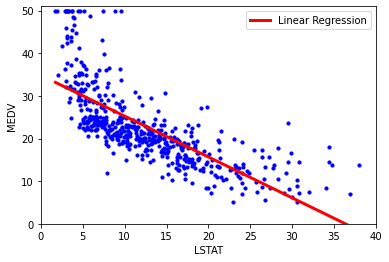

In [98]:
#x_train, x_test, y_train, y_test = train_test_split(, , test_size=0.25, random_state=5)
kf = KFold(n_splits=10)
loss_values = []
for train_index, test_index in kf.split(x):
    #print("train:", train_index.shape, "test:", test_index.shape)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    cx_train = sm.add_constant(x_train)
    lr = sm.OLS(y_train, cx_train).fit()

    x_axis = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_axis = lr.predict(sm.add_constant(x_axis))

    y_pred = lr.predict(sm.add_constant(x_test))
    loss_values.append(mean_squared_error(y_test, y_pred))

print(np.array(loss_values).mean())

plt.xlim(0, 40); plt.ylim(0, 51)
plt.scatter(x, y, s=10, c='blue')
plt.plot(x_axis, y_axis, 'r-', lw=3, label="Linear Regression")
#plt.scatter(x_test.reshape(-1, 1), y_pred, lw=4, s=10, c='blue')
plt.xlabel("LSTAT"); plt.ylabel("MEDV")
plt.legend()
plt.show()



29.992554246132546


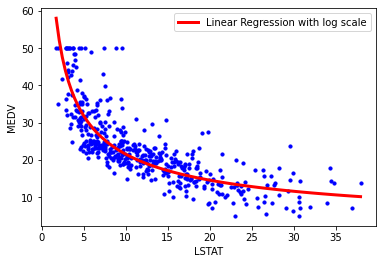

In [99]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
kf = KFold(n_splits=10)
loss_values = []
for train_index, test_index in kf.split(x):
    #print("train:", train_index.shape, "test:", test_index.shape)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    logx = np.log(x_train); logy = np.log(y_train)
    lr = sm.OLS(logy, sm.add_constant(logx)).fit()

    cx_test = sm.add_constant(np.log(x_axis))
    logy_axis = lr.predict(cx_test)

    y_pred = lr.predict(sm.add_constant(np.log(x_test)))

    loss_values.append(mean_squared_error(y_test, np.exp(y_pred)))

print(np.array(loss_values).mean())

#plt.xlim(0, 100); plt.ylim(0, 100)
#plt.xscale("log"); plt.yscale("log")

plt.scatter(x_train, y_train, s=10, c='blue')
plt.plot(x_axis, np.exp(logy_axis), 'r-', lw=3, label="Linear Regression with log scale")
plt.xlabel("LSTAT"); plt.ylabel("MEDV")
plt.legend()
plt.show()

<ipython-input-100-b68a2f871eae>:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
<ipython-input-100-b68a2f871eae>:3: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c
test loss: 24.813859721339092


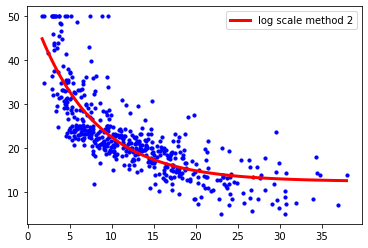

In [100]:
from scipy.optimize import curve_fit
def log(x, a, b, c):
    return a * np.exp(-b * x) + c

x = boston.data[:,-1]; y = boston.target
popt, pcov = curve_fit(log, x, y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print("test loss:", mean_squared_error(y_test, log(x_test, *popt)))

plt.scatter(x, y, s=10, c='blue')
plt.plot(x_axis, log(x_axis, *popt), 'r-', lw=3, label="log scale method 2")
plt.legend()
plt.show()

In [101]:
alpha = 1
n = 100
degree = 8
pardim = degree+1

x = boston.data[:,-1]; y = boston.target

spr_x = np.power.outer(x, np.arange(pardim))
print("x's shape:", x.shape, "; super x's shape:", spr_x.shape)

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)


kf = KFold(n_splits=10)
ls = ['-', '--', '-.', ':']
a = np.array([0, 2**(-6), 1, 10, 100]) # 正則化パラメータの候補

for i in np.arange(a.size):
    loss_values = []
    for train_index, test_index in kf.split(spr_x):
        x_train, x_test = spr_x[train_index], spr_x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        IE = np.identity(x_train.shape[1]); IE[0,0] = 0
        theta = np.linalg.solve(np.dot(x_train.T, x_train) + a[i] * IE, np.dot(x_train.T, y_train))
        y_pred = np.dot(x_test, theta)
        loss_values.append(mean_squared_error(y_test, y_pred))
        
    print(a[i], np.array(loss_values).mean())

x's shape: (506,) ; super x's shape: (506, 9)
0.0 30.511232986228105
0.015625 30.503661637961027
1.0 30.41573155892268
10.0 30.328567176676454
100.0 30.405545496025248


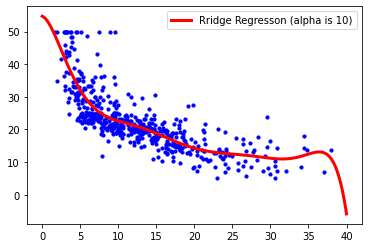

In [102]:
alpha = 10
x = boston.data[:,-1]; y = boston.target
spr_x = np.power.outer(x, np.arange(pardim))
x_axis = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)

IE = np.identity(spr_x.shape[1]); IE[0,0] = 0
theta = np.linalg.solve(np.dot(spr_x.T, spr_x) + alpha * IE, np.dot(spr_x.T, y))

plt.scatter(x, y, s=10, c='blue') # データ点プロット

x_axis = np.linspace(0, 40, spr_x.shape[0])
spr_x_axis = np.power.outer(x_axis, np.arange(pardim))
y_axis = np.dot(spr_x_axis, theta)
plt.plot(x_axis, y_axis, 'r-', lw=3, label="Ridge Regresson (alpha is {})".format(alpha), )

plt.legend()
plt.show()

0.01 31.697581950775213
0.1 30.640795345473727
0.0 92.08329925792152
1.0 34.109991518158175
No handles with labels found to put in legend.
10.0 48.00877582447124
100.0 101.27588820545786


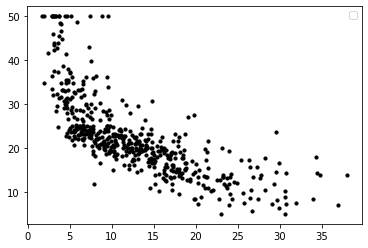

In [103]:
from sklearn.kernel_ridge import KernelRidge
g = np.array([0.01,0.1,0,1,10,100])
x = boston.data[:,-1].reshape(-1, 1); y = boston.target
x_axis = np.linspace(x.min(), x.max(), 100) # テスト点
plt.scatter(x, y, c='black', s=10) # データ点プロット
ls = ['-', '--', '-.', ':']

for i in np.arange(len(g)):
    loss_values = []
    for train_index, test_index in kf.split(spr_x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        kr = KernelRidge(alpha=1, kernel='rbf', gamma=g[i])
        kr.fit(x_train, y_train)
        y_axis = kr.predict(x_axis.reshape(-1,1))
        y_pred = kr.predict(x_test.reshape(-1,1))

        loss_values.append(mean_squared_error(y_test, y_pred))

    #plt.plot(x_axis, y_axis, label="gamma: " + str(round(g[i],3)), ls=ls[i])

    print(g[i], np.array(loss_values).mean())

plt.legend()
plt.show()